### Looking at a wider spectrum of speakers (not only politicians)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools

In [6]:
# Dataframe with american speakers in Quotebank and their information
americans = pd.read_csv("data/americans.csv")

In [7]:
americans.head()

,Unnamed: 0,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,1,['George Walker Bush' 'Bush Jr.' 'Dubya' 'GWB'...,['+1946-07-06T00:00:00Z'],['Q30'],['Q6581097'],1395142029,NaN,NaN,['Q82955' 'Q15982858' 'Q18814623' 'Q1028181' '...,['Q29468'],NaN,Q207,George W. Bush,['Q327959' 'Q464075' 'Q3586276' 'Q4450587'],item,['Q329646' 'Q682443' 'Q33203']
1,2,['Neil Percival Young' 'Shakey' 'Godfather of ...,['+1945-11-12T00:00:00Z'],['Q16' 'Q30'],['Q6581097'],1395459626,NaN,NaN,['Q177220' 'Q488205' 'Q2526255' 'Q639669' 'Q18...,NaN,NaN,Q633,Neil Young,NaN,item,NaN
2,3,['Mary Louise Streep' 'Meryl Louise Streep' 'S...,['+1949-06-22T00:00:00Z'],['Q30'],['Q6581072'],1388232380,NaN,NaN,['Q10800557' 'Q2259451' 'Q10798782' 'Q2405480'...,['Q29552'],NaN,Q873,Meryl Streep,NaN,item,['Q7066']
3,4,NaN,['+1947-10-01T00:00:00Z'],['Q30'],['Q6581097'],1291441158,NaN,NaN,['Q3630699' 'Q54845077'],NaN,NaN,Q1381,Dave Arneson,NaN,item,NaN
4,5,['Ashton James Eaton'],['+1988-01-21T00:00:00Z'],['Q30'],['Q6581097'],1395347414,['Q49085'],NaN,['Q14605941'],NaN,NaN,Q1789,Ashton Eaton,NaN,item,NaN


In [8]:
# Dataframes with quotes
df15_all = pd.read_csv("data/df15_all.csv")
df16_all = pd.read_csv("data/df16_all.csv")
df17_all = pd.read_csv("data/df17_all.csv")
df18_all = pd.read_csv("data/df18_all.csv")
df19_all = pd.read_csv("data/df19_all.csv")
df20_all = pd.read_csv("data/df20_all.csv")

In [9]:
speakers15 = df15_all.speaker
speakers16 = df16_all.speaker
speakers17 = df17_all.speaker
speakers18 = df18_all.speaker
speakers19 = df19_all.speaker
speakers20 = df20_all.speaker

speakers = [speakers15, speakers16, speakers17, speakers18, speakers19, speakers20]

In [10]:
total15 = df15_all.shape[0]
total16 = df16_all.shape[0]
total17 = df17_all.shape[0]
total18 = df18_all.shape[0]
total19 = df19_all.shape[0]
total20 = df20_all.shape[0]

totals = [total15, total16, total17, total18, total19, total20]

In [11]:
years = [2015, 2016, 2017, 2018, 2019, 2020]

### Political Party of Speakers

In [12]:
# Create a dataframe with the counts of each political party QID for each year
pol_party = pd.DataFrame()
for i, s in enumerate(speakers):
    parties = pd.DataFrame(americans[americans.label.isin(s)].party)
    parties.party = parties.party.astype(str)
    parties.party = parties.party.map(lambda x: x.lstrip("['").rstrip("]'"))
    parties.party = parties.party.map(lambda x: x.replace("' '", ' '))
    parties = parties[~(parties.party == 'nan')]
    parties = parties.value_counts().head(10)
    parties = pd.DataFrame(parties).reset_index()
    parties.columns = ['qid', 'ct']
    parties['year'] = i+2015
    pol_party = pol_party.append(parties)
pol_party

,qid,ct,year
0,Q29552,845,2015
1,Q29468,620,2015
2,Q29468 Q29552,18,2015
3,Q29552 Q29468,15,2015
4,Q1937395 Q29552,14,2015
5,Q5020399,7,2015
6,Q327591,7,2015
7,Q7314659 Q29468,7,2015
8,Q558334,6,2015
9,Q6064351 Q29552,6,2015


In [13]:
# Create a dataframe with the political party QIDs and their labels
qids = ['Q29552', 'Q29468', 'Q29468 Q29552', 'Q29552 Q29468', 'Q1937395 Q29552',
       'Q5020399', 'Q327591']
labels = ['democrat', 'republican', 'democrat/republican', 'democrat/republican', 'minnesota democrat-farmer-labor', 'democrat', 'independent']

data = list(zip(qids, labels))
party_QID = pd.DataFrame(data, columns = ['qid', 'party'])
party_QID.head()

,qid,party
0,Q29552,democrat
1,Q29468,republican
2,Q29468 Q29552,democrat/republican
3,Q29552 Q29468,democrat/republican
4,Q1937395 Q29552,minnesota democrat-farmer-labor


In [14]:
# Merge the two dataframes to get the labels and the counts together
merged_party = pd.merge(pol_party, party_QID)
merged_party.head()

,qid,ct,year,party
0,Q29552,845,2015,democrat
1,Q29552,660,2016,democrat
2,Q29552,932,2017,democrat
3,Q29552,995,2018,democrat
4,Q29552,849,2019,democrat


#### Comparing the number of quotes about gay rights from democrats and republicans for all years

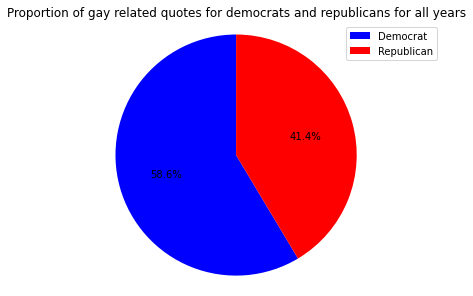

In [15]:
pie_chart = merged_party.drop(['qid', 'year'], axis = 1).groupby('party').sum().sort_values(by = 'ct', ascending=False).head(2)
pie_counts = pie_chart['ct']
pie_labels = pie_chart.index

labels = pie_labels.str.title()
sizes = pie_counts
colors = ['blue', 'red']
patches, texts, junk = plt.pie(sizes, colors=colors, startangle=90, autopct='%1.1f%%')
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.title("Proportion of gay related quotes for democrats and republicans for all years")
plt.show()

The democrats represent 58.6% of quotes while the republicans 41.4%. In other terms, democrats tend to talk more about gay topics.  

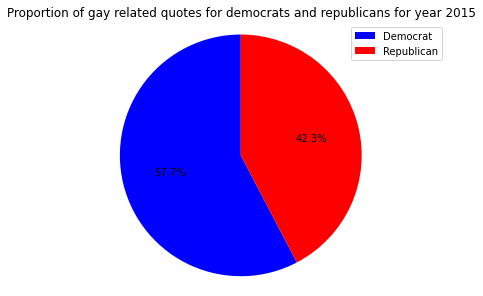

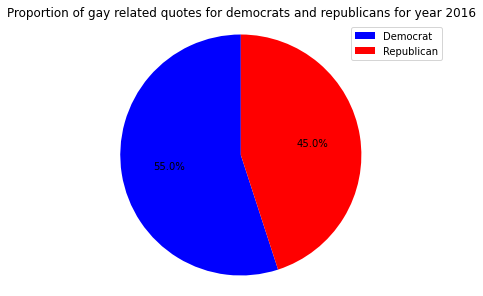

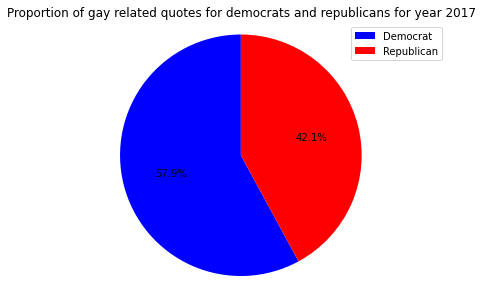

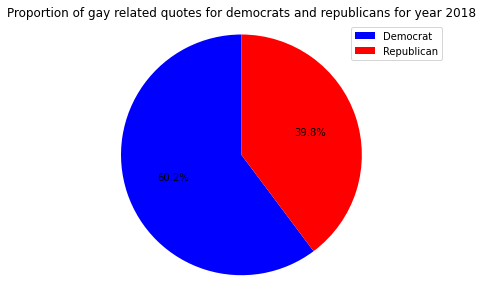

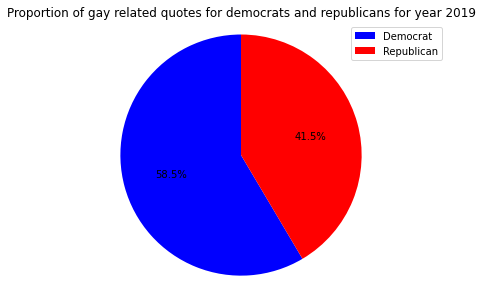

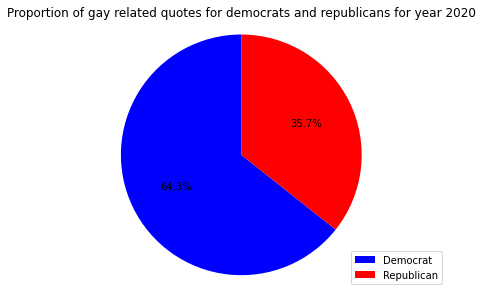

In [16]:
# Looks at each year individually:
for yr in years:
    piechart = merged_party[(merged_party.year == yr)].head(2)
    pie_counts = piechart.ct
    pie_labels = piechart.party

    labels = pie_labels.str.title()
    sizes = pie_counts
    colors = ['blue', 'red']
    patches, texts, junk = plt.pie(sizes, colors=colors, startangle=90, autopct='%1.1f%%')
    plt.legend(patches, labels, loc="best")
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.tight_layout()
    plt.title("Proportion of gay related quotes for democrats and republicans for year {}".format(yr))
    plt.show()

These charts don't tell us much, however we can see that between year 2016 and 2020 there was a 10% increase in gay related quotes for democrats implying an almost 10% decrease for the republicans.

### Occupations of speakers

In [17]:
# Create a dataframe with the most common occupations of speakers for each year (for quotes related to gay rights)
occs = pd.DataFrame()
for i, s in enumerate(speakers):
    occupations = pd.DataFrame(americans[americans.label.isin(s)].occupation)
    occupations['occupation'] = occupations['occupation'].astype(str)
    occupations['occupation'] = occupations['occupation'].map(lambda x: x.lstrip("['").rstrip("]'"))
    occupations['occupation'] = occupations['occupation'].map(lambda x: x.replace("' '", ' '))
    occupations['occupation'] = occupations['occupation'].map(lambda x: x.replace("'\n '", ' '))
    occupations['occupation'] = occupations['occupation'].map(lambda x: x.split())
    occupations_list = list(itertools.chain(occupations['occupation']))
    occupations_list  = pd.DataFrame([item for sublist in occupations_list for item in sublist], columns = ['qid'])
    occupations_list = occupations_list[~(occupations_list == 'nan')]
    o = occupations_list.value_counts().head(45)
    o = pd.DataFrame(o).reset_index()
    o.columns = ['qid', 'ct']
    o['year'] = i+2015
    occs = occs.append(o)
occs.head()

,qid,ct,year
0,Q82955,1376,2015
1,Q33999,1147,2015
2,Q36180,943,2015
3,Q10798782,873,2015
4,Q10800557,807,2015


In [18]:
# Create a dataframe of the QIDs and labels for occupations
qids = ['Q82955', 'Q33999', 'Q36180', 'Q10798782', 'Q10800557', 'Q1930187',
       'Q19204627', 'Q28389', 'Q177220', 'Q40348', 'Q3282637', 'Q2405480',
       'Q639669', 'Q2526255', 'Q3665646', 'Q578109', 'Q10871364', 'Q2259451',
       'Q36834', 'Q43845', 'Q488205', 'Q6625963', 'Q1622272', 'Q4610556',
       'Q753110', 'Q855091', 'Q183945', 'Q245068', 'Q2722764', 'Q947873',
       'Q482980', 'Q937857', 'Q33231', 'Q131524', 'Q5137571', 'Q49757',
       'Q201788', 'Q37226', 'Q11774891', 'Q8246794', 'Q19509201', 'Q81096', 'Q1028181', 'Q483501', 'Q15077007']
labels = ['politician', 'actor', 'writer', 'actor', 'actor', 'journalist', \
          'american football player', 'screenwriter', 'singer', 'lawyer', 'film producer', 'actor', \
          'musician', 'film director', 'basketball player', 'television producer', 'baseball player', 'actor', \
          'composer', 'businessperson', 'singer', 'novelist', 'professor', 'model', \
          'songwriter', 'guitarist', 'record producer', 'comedian', 'radio personality', 'television presenter', \
          'author', 'football player', 'photographer', 'entrepreneur', 'basketball coach', 'poet', \
          'historian', 'teacher', 'ice hockey player', 'blogger', 'LGBTI rights activist', 'engineer', 'painter', \
          'artist', 'podcaster']
data = list(zip(qids, labels))
occupation_QID = pd.DataFrame(data, columns = ['qid', 'occupation'])
occupation_QID.head()

,qid,occupation
0,Q82955,politician
1,Q33999,actor
2,Q36180,writer
3,Q10798782,actor
4,Q10800557,actor


In [19]:
# Merge the two dataframes
merged_occ = pd.merge(occs, occupation_QID)
merged_occ = merged_occ.drop('qid', axis=1)
merged_occ.head()

,ct,year,occupation
0,1376,2015,politician
1,1123,2016,politician
2,1545,2017,politician
3,1559,2018,politician
4,1355,2019,politician


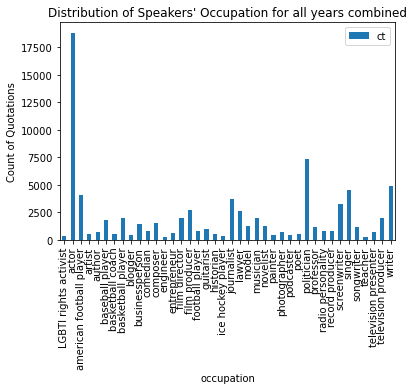

In [20]:
# Distribution of genders for all years
barchart_all = merged_occ.drop(['year'], axis=1).groupby('occupation').sum().reset_index()
barchart_all.plot.bar(x='occupation', y='ct', rot=90)
plt.title("Distribution of Speakers' Occupation for all years combined")
plt.ylabel("Count of Quotations")
plt.show()

From this first plot, we can see that the 'actor' occupation seems to be prominent in terms of speakers. In our opinion this makes sense for different reasons:
- actors often/sometimes have to play the role of a lgbtqia+ person
- actors are often quoted in the media in case of a coming out or an opinion 

In [21]:
top10 = merged_occ.drop(['year'], axis = 1).groupby('occupation').sum().sort_values(by = 'ct', ascending=False).head(10)
other_ct = merged_occ.ct.sum() - top10.ct.sum()
top10.loc['other'] = other_ct
top10

,ct
occupation,
actor,18852
politician,7386
writer,4886
singer,4527
american football player,4107
journalist,3670
screenwriter,3234
film producer,2696
lawyer,2634


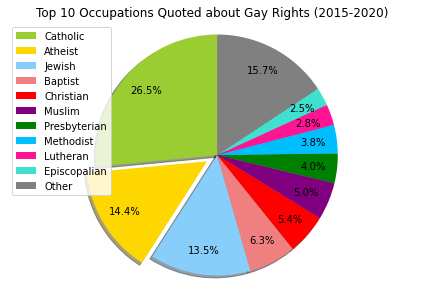

In [51]:
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
labels = top10.index.str.title()
sizes = top10.ct
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red', 'purple', 'green', 'deepskyblue', 'deeppink', 'turquoise', 'grey']
patches, texts, junk = plt.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, autopct='%1.1f%%', pctdistance=0.8) 
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.title("Top 10 Occupations Quoted about Gay Rights (2015-2020)")
plt.show()

Here is a more meaningful representation of the occupations. We can clearly see the decreasing order and prominence of some occupations. Indeed, **actors** are clearly the prominent, quite far behind are the **politicians** and the other occupations are way less represented. One could find surprising that politicians represent 9.1% while actors represent 23.3%. Politicians are the ones who can apply laws and create change, in both directions, depending on the opinion. So we could ask ourselves if this result is due to our data which might not be exhaustive or if it is real. In the last case, another question arises: **why do politicians talk less about this topic?** Is it a taboo matter? Is it because they should only speak to state new reforms? 
Finally, 33% belong to the **'Other'** category. This could indicate that our data are not that reliable and it could be an answer to the question 'why do politicians talk less about this topic?'.

### Focus on gender per speaker

In [29]:
# Create a dataframe with the gender QIDs and their labels
qids = ['Q6581097', 'Q6581072', 'Q1052281', 'Q48270', 'Q2449503', 'Q1097630', 'Q18116794', \
                           'Q859614', 'Q27679766', 'Q15145779', 'Q12964198', 'Q6581072 Q48270', \
       'Q1097630 Q48270', 'Q6581097 Q18116794', 'Q1052281 Q6581097', 'Q18116794 Q6581097', \
       'Q27679766 Q859614', 'Q15145778', 'Q1984232', 'Q48279', 'Q48279 Q1097630', 'Q505371', \
       'Q48270 Q505371', 'Q189125', 'Q6581097 Q189125', 'Q48270 Q6581072', 'Q48270 Q12964198', \
       'Q1097630 Q48279']
labels = ['male', 'female', 'transgender female', 'non-binary', 'transgender male', \
                           'intersex', 'gender fluid', 'bigender', 'transmasculine', 'cisgender female', \
                           'gender queer', 'female non-binary', 'intersex non-binary', 'gender fluid male', \
         'male transgender female', 'gender fluid male', 'transmasculine bigender', 'cisgender male', 'shemale', 'third gender', \
         'intersex third gender', 'agender', 'non-binary agender', 'transgender person', 'male transgender person', \
         'female non-binary', 'gender queer non-binary', 'intersex third gender']
data = list(zip(qids, labels))
gender_QID = pd.DataFrame(data, columns = ['str_qid', 'gender'])
gender_QID.head()

,str_qid,gender
0,Q6581097,male
1,Q6581072,female
2,Q1052281,transgender female
3,Q48270,non-binary
4,Q2449503,transgender male


In [31]:
# For each year, count the number of quotes per gender, add the year and total number of quotes as other columns
counts_gender = pd.DataFrame()
for i, s in enumerate(speakers):
    counts_tmp = pd.DataFrame(americans[americans.label.isin(s)].gender.value_counts()).reset_index()
    counts_tmp['index'] = counts_tmp['index'].map(lambda x: x.lstrip("['").rstrip("]'"))
    counts_tmp['index'] = counts_tmp['index'].map(lambda x: x.replace("' '", ' '))
    counts_tmp['index'] = counts_tmp['index'].str.split()
    counts_tmp = counts_tmp.rename(columns = {'index': 'qid', 'gender': 'ct'})
    counts_tmp['str_qid'] = counts_tmp['qid'].apply(lambda x: " ".join(x))
    counts_tmp['year'] = years[i]
    counts_tmp['total_quotes'] = totals[i]
    counts_gender = counts_gender.append(counts_tmp)
    counts_gender = counts_gender.drop('qid', axis=1)
    
counts_gender.head()

,ct,str_qid,year,total_quotes
0,6997,Q6581097,2015,23591
1,2111,Q6581072,2015,23591
2,68,Q1052281,2015,23591
3,22,Q48270,2015,23591
4,20,Q2449503,2015,23591


In [32]:
# Merge the counts and gender dataframes to get the gender labels
merged_gender = pd.merge(counts_gender, gender_QID, on='str_qid')
merged_gender = merged_gender[~merged_gender.gender.isnull()]
merged_gender.head()

,ct,str_qid,year,total_quotes,gender
0,6997,Q6581097,2015,23591,male
1,5318,Q6581097,2016,15092,male
2,7768,Q6581097,2017,27336,male
3,7929,Q6581097,2018,27043,male
4,7123,Q6581097,2019,25926,male


In [33]:
# Look at the counts on a log scale
merged_gender['logcount'] = np.log(merged_gender.ct.astype(float))

In [34]:
# Only look at genders with a positive count
merged_gender_bar = merged_gender[merged_gender.logcount > 0]

#### Distribution of Gender

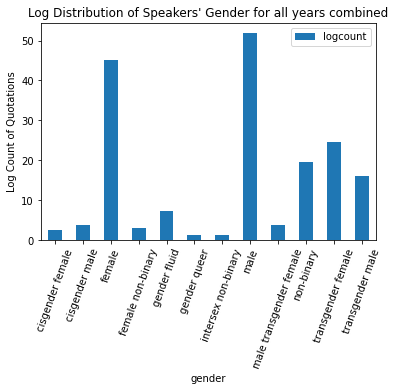

In [36]:
# Distribution of genders for all years
barchart_all = merged_gender_bar.drop(['str_qid', 'total_quotes', 'ct', 'year'], axis=1).groupby('gender').sum().reset_index()
barchart_all.plot.bar(x='gender', y='logcount', rot=70)
plt.title("Log Distribution of Speakers' Gender for all years combined")
plt.ylabel("Log Count of Quotations")
plt.show()

As we can see males seem to be the one talking the more about lgbtqia+ topics. Female are close. But there is a gap with the genders belonging to this community. Is it because people in this community sometimes suffer from a lack of visibility in the media for e.g? Is it because our data contain a bias? Is it because some speakers in the category 'female' or 'male' could belong to lgbtq+ categories but didn't state this? Or is it because these communities are way smaller? 

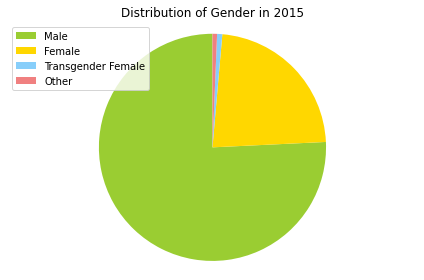

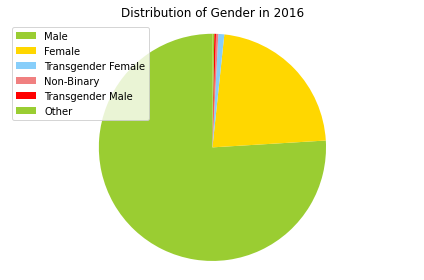

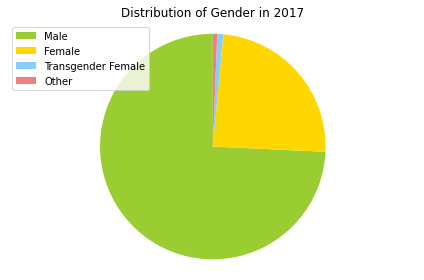

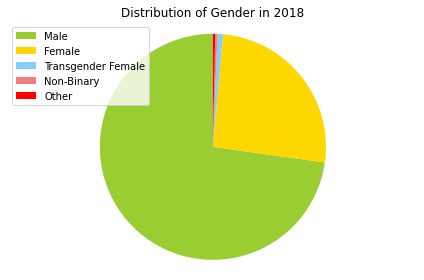

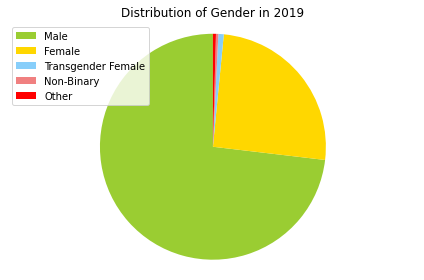

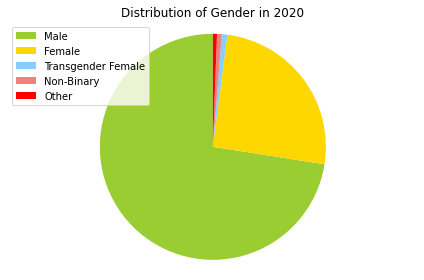

In [39]:
# Pie Charts of Gender by Year:
for yr in years:
    piechart = merged_gender[(merged_gender.year == yr) & (merged_gender.ct.astype(float)/merged_gender.total_quotes.astype(float) > 0.001)]
    pie_counts = piechart.ct
    pie_labels = piechart.gender

    pie_counts = pie_counts.append(pd.Series(merged_gender.ct[(merged_gender.year == yr) & ~(merged_gender.ct.astype(float)/merged_gender.total_quotes.astype(float) > 0.001)].sum()))
    pie_labels = pie_labels.append(pd.Series('Other'))

    labels = pie_labels.str.title()
    sizes = pie_counts
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red']
    patches, texts = plt.pie(sizes, colors=colors, startangle=90)
    plt.legend(patches, labels, loc="best")
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title("Distribution of Gender in " + str(yr))
    plt.tight_layout()
    plt.show()

It seems that the distributions did not change over the years. 

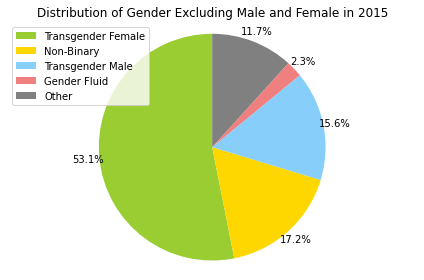

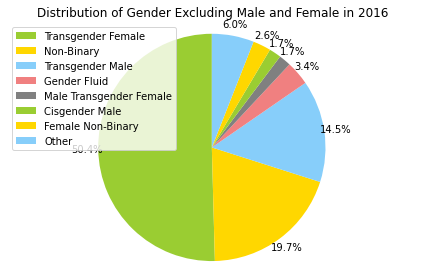

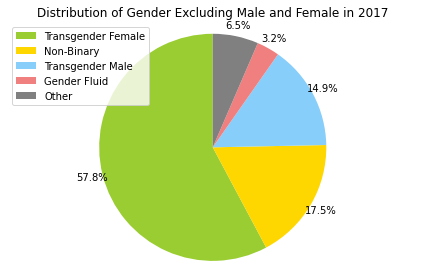

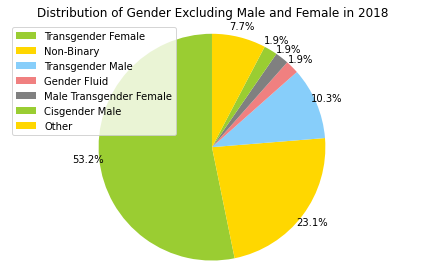

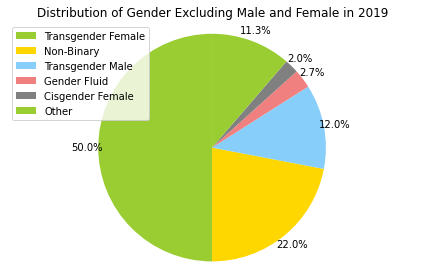

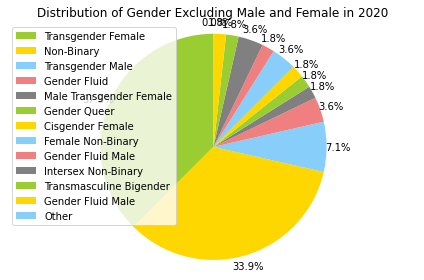

In [30]:
# Look at distribution ignoring male and female
# See significantly more genders in 2020
for yr in years:
    without_mf = merged_gender[(merged_gender.year == yr) & ~(merged_gender.gender.isin(['male', 'female']))]
    piechart = without_mf[without_mf.ct.astype(float)/without_mf.total_quotes.astype(float) > 0.0001]
    other_ct = without_mf.ct.sum() - piechart.ct.sum()
    piechart = piechart.drop(['str_qid', 'year', 'logcount', 'total_quotes'], axis=1).set_index('gender')
    piechart.loc['other'] = other_ct

    labels = piechart.index.str.title()
    sizes = piechart.ct
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'grey']
    patches, texts, junk = plt.pie(sizes, colors=colors, startangle=90, autopct='%1.1f%%', pctdistance=1.1)
    plt.legend(patches, labels, loc="best")
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title("Distribution of Gender Excluding Male and Female in " + str(yr))
    plt.tight_layout()
    plt.show()

Over the years, we observe the emergence of more different kinds of gender identities. 
Moreover, as we didn't represent the male and female gender in these plot, it is easier to see the prominence of transgender females as speakers over the years, with behind the non-binary who took more importance in 2020. 

### Religion

In [44]:
# Create a dataframe with the religion QIDs and their labels
qids = ['Q9592', 'Q9268', 'Q7066', 'Q432', 'Q1841', 'Q5043', 'Q93191', 'Q75809', 'Q33203', 'Q748', 'Q9089', \
       'Q178169', 'Q42504' 'Q682443', 'Q23540', 'Q9268 Q5043', 'Q1622507', 'Q288928', 'Q1351880', 'Q7361618', \
       'Q9592 Q7361618', 'Q6423963', 'Q329646', 'Q483654', 'Q1841 Q7361618', 'Q3333484', 'Q5043 Q9268', 'Q346575', \
       'Q131036', 'Q747802', 'Q13211738', 'Q194253', 'Q217059', 'Q104319', 'Q1062789']
labels = ['catholic', 'jewish', 'atheist', 'muslim', 'catholic', 'christian', 'baptist', 'lutheran', 'methodist', \
         'buddhist', 'hindu', 'presbyterian', 'latter-day saint', 'episcopalian', 'protestant', 'jewish/christian', \
         'unitarian', 'agnostic', 'southern baptist', 'catholic', 'catholic', 'anglican', 'united methodist', \
         'sunni muslim', 'catholic', 'eastern orthodox', 'jewish/christian', 'protestant', 'scientology', 'mormon', \
         'atheist', 'evangelical', 'unificationist', 'seventh-day adventist', 'congregationalist']
data = list(zip(qids, labels))
religion_QID = pd.DataFrame(data, columns = ['str_qid', 'religion'])
religion_QID.head()

,str_qid,religion
0,Q9592,catholic
1,Q9268,jewish
2,Q7066,atheist
3,Q432,muslim
4,Q1841,catholic


In [45]:
# For each year, count the number of quotes per religion, add the year and total number of quotes as other columns
speakers = [speakers15, speakers16, speakers17, speakers20]
years = [2015, 2016, 2017, 2020]
totals = [total15, total16, total17, total20]
counts_rel = pd.DataFrame()
for i, s in enumerate(speakers):
    counts_tmp = pd.DataFrame(americans[americans.label.isin(s)].religion.value_counts()).reset_index()
    counts_tmp['index'] = counts_tmp['index'].map(lambda x: x.lstrip("['").rstrip("]'"))
    counts_tmp['index'] = counts_tmp['index'].map(lambda x: x.replace("' '", ' '))
    counts_tmp['index'] = counts_tmp['index'].str.split()
    counts_tmp = counts_tmp.rename(columns = {'index': 'qid', 'religion': 'ct'})
    counts_tmp['str_qid'] = counts_tmp['qid'].apply(lambda x: " ".join(x))
    counts_tmp['year'] = years[i]
    counts_tmp['total_quotes'] = totals[i]
    counts_rel = counts_rel.append(counts_tmp)

    counts_rel = counts_rel.drop('qid', axis=1)
counts_rel.head()

,ct,str_qid,year,total_quotes
0,113,Q9592,2015,23591
1,91,Q7066,2015,23591
2,90,Q9268,2015,23591
3,57,Q1841,2015,23591
4,48,Q93191,2015,23591


In [46]:
merged_religion = pd.merge(counts_rel, religion_QID, on='str_qid')
merged_religion = merged_religion[~merged_religion.religion.isnull()]
merged_religion.head()

,ct,str_qid,year,total_quotes,religion
0,113,Q9592,2015,23591,catholic
1,74,Q9592,2016,15092,catholic
2,108,Q9592,2017,27336,catholic
3,24,Q9592,2020,5016,catholic
4,91,Q7066,2015,23591,atheist


In [47]:
top10 = merged_religion.drop(['year', 'str_qid', 'total_quotes'], axis = 1).groupby('religion').sum().sort_values(by = 'ct', ascending=False).head(10)
other_ct = merged_religion.ct.sum() - top10.ct.sum()
top10.loc['other'] = other_ct
top10

,ct
religion,
catholic,540
atheist,294
jewish,275
baptist,129
christian,111
muslim,102
presbyterian,81
methodist,78
lutheran,57


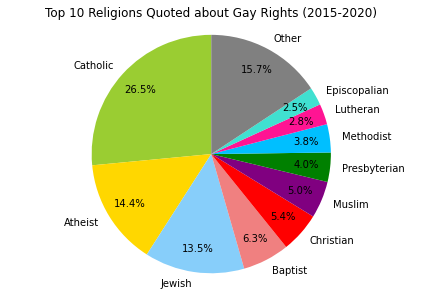

In [49]:
labels = top10.index.str.title()
sizes = top10.ct
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red', 'purple', 'green', 'deepskyblue', 'deeppink', 'turquoise', 'grey']
patches, texts, junk = plt.pie(sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%', pctdistance=0.8, labeldistance = 1.1)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.title("Top 10 Religions Quoted about Gay Rights (2015-2020)")
plt.show()

Catholic, jewish and atheist are the ones talking the more about lgbtqia+ related topics apparently. 

## Topic Modeling

In [52]:
from lda_functions import *

C:\Users\Pont Naomie\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Pont Naomie\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar'

ModuleNotFoundError: No module named 'deep_translator'

In [53]:
dfs = [df15_all, df16_all, df17_all, df18_all, df19_all, df20_all]
for i, df in enumerate(dfs):
    print("\n", i + 2015, "\n")
    # only consider words that we didn't provide and remove some other irrelevant words
    df_clean = df.quotation.apply(lambda x: remove_keywords(x))
    data_lemmatized = nlp_pipe(df_clean)
    corpus, id2word = create_corpus(data_lemmatized)
    p, c, lda_model = run_lda(data_lemmatized, corpus, id2word, 3)
    word_bubble(lda_model, 3)
    #view_word_counts(lda_model, data_lemmatized, 2)


 2015 



C:\Users\Pont Naomie\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'remove_keywords' is not defined